In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
from function.utilities import get_subset

# param

In [2]:
#####CHANGE HERE#####
algorithm = 'VL3-BA'
#####CHANGE HERE#####

# load data

In [3]:
pondr_disorder_identification_path = Path("./output/pondr_disorder_identification")
od_human_df = pd.read_pickle(pondr_disorder_identification_path/'{}_od_human_df.pkl'.format(algorithm))
od_rbp_df = get_subset(od_human_df,'rbp')
od_mrbp_df = get_subset(od_human_df,'mrbp')

# consecutive disordered stat

In [4]:
#微小差距是因為我用>= 老施用 >

In [5]:
def length_filter(disorder_length,od_ident):
    
    count = 0
    for i in od_ident:
        if i == '1':
            count = count + 1
            if count > disorder_length:
                return 1
        else:
            count = 0
            
    return 0

def make_consecutive_disorder_stat(df):
    
    df['>30'] = df['od_ident'].apply(lambda x: length_filter(30,x))
    df['>40'] = df['od_ident'].apply(lambda x: length_filter(40,x))
    df['>50'] = df['od_ident'].apply(lambda x: length_filter(50,x))
    
    b30 = df['>30'].value_counts()[1] / len(df)
    b40 = df['>40'].value_counts()[1] / len(df)
    b50 = df['>50'].value_counts()[1] / len(df)
    
    b30 = round(b30 * 100,2)
    b40 = round(b40 * 100,2)
    b50 = round(b50 * 100,2)
    
    return {">30":b30,
            ">40":b40,
            ">50":b50}

In [6]:
mrbp = make_consecutive_disorder_stat(od_mrbp_df)
rbp = make_consecutive_disorder_stat(od_rbp_df)
human = make_consecutive_disorder_stat(od_human_df)

# output

In [7]:
output = {"algorithm":algorithm,
          "human":human,
          "rbp":rbp,
          "mrbp":mrbp}

In [8]:
output

{'algorithm': 'VL3-BA',
 'human': {'>30': 75.47, '>40': 67.81, '>50': 61.03},
 'rbp': {'>30': 87.35, '>40': 80.23, '>50': 73.58},
 'mrbp': {'>30': 89.97, '>40': 83.87, '>50': 78.63}}

# plot

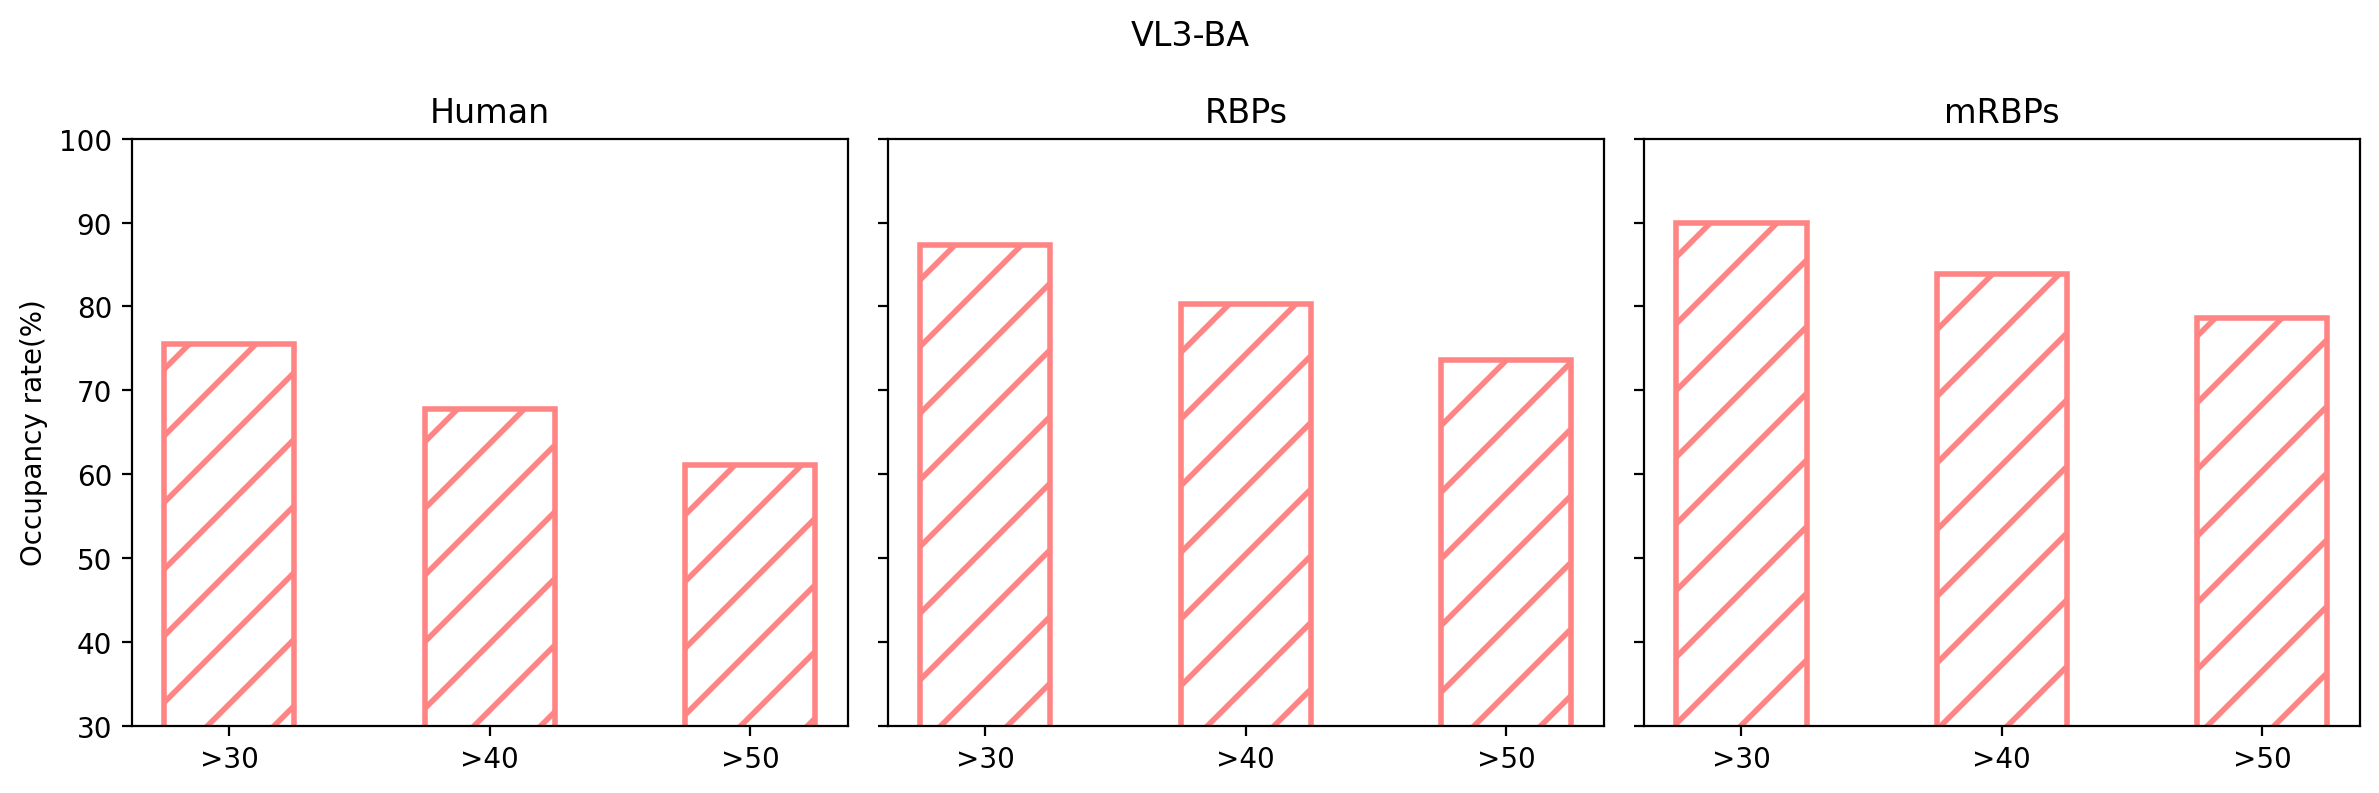

In [9]:
mpl.rcParams['hatch.linewidth'] = 2
f, (a0,a1,a2) = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4),dpi=200)

percentage_label = list(output['mrbp'].keys())
X = np.arange(0,len(output['mrbp']))

a0.bar(X,output['human'].values(),width=0.5,tick_label=percentage_label,color='white',hatch='/',linewidth=2,edgecolor='#ff8484')
a0.set_title("Human")
a0.set_ylabel("Occupancy rate(%)")
a0.set_ylim(30,100)

a1.bar(X,output['rbp'].values(),width=0.5,tick_label=percentage_label,color='white',hatch='/',linewidth=2,edgecolor='#ff8484')
a1.set_title("RBPs")

a2.bar(X,output['mrbp'].values(),width=0.5,tick_label=percentage_label,color='white',hatch='/',linewidth=2,edgecolor='#ff8484')
a2.set_title("mRBPs")


f.suptitle(algorithm)
f.tight_layout()